In [12]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from math import sqrt, exp

In [2]:
def read_and_convert_data(data_path, labels_path):
    """
    read_and_convert_data_points is a function that takes
    a text file as an argument and converts it into an 
    array containing all the datapoints.
    ======================================================
    :param filename: text file name in directory.
    :return: Npts x 2 array, labels vector of length Npts. 
    ======================================================
    """
    splits = []
    with open(data_path, 'r') as d, open(labels_path, 'r') as l:
                data_points = d.readlines()
                data_labels = l.readlines()
    
    for data_point in data_points:
        splits.append(data_point.split())
    
    return (np.array(splits, dtype=np.float),
            np.array(data_labels, dtype=np.int))

In [3]:
def scatter_plot(data,labels):
    """
    scatter_plot is a function that plots the data.
     ======================================================
    :param data: Npts x 2, data set array.
    :labels: Npts labels vector.
    :return:
     ======================================================
    """
    x, y = data_points.T
    colors = ['red','orange','blue']
    plt.scatter(x,y,c=labels, 
                cmap=matplotlib.colors.ListedColormap(colors))
    plt.show()

In [5]:
def eucledian_dist(x_i, x_j):
    coord = x_i.shape[0]
    d=[]
    if coord == x_j.shape[0]:
        for i in range(coord):
            d.append((x_i[i] - x_j[i])**2)
    return sqrt(sum(d))

In [6]:
def distance_matrix(data, distance_measure):
    Npts= data.shape[0]
    distance_matrix=np.zeros((Npts,Npts))
    for xi in range(Npts):
        for xj in range(Npts):
            distance_matrix[xi,xj] = distance_measure(data[xi],data[xj])
    return(distance_matrix)

In [ ]:
def adjacency_matrix(data, sigma):
    dist_matrix = distance_matrix(test_matrix, eucledian_dist)
    adjacency_matrix= np.exp(-(dist_matrix)**2 /sigma)
    adjacency_matrix[adjacency_matrix==1] = 0
    return(adjacency_matrix)

In [ ]:
def diagonal_matrix(adjacency_matrix):
    return(np.diag(sum(adjacency_matrix)))

In [27]:
adjacency_matrix= np.exp(-(distance_matrix(test_matrix,eucledian_dist))**2 /0.5)
adjacency_matrix[adjacency_matrix==1] = 0

In [7]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [10]:
data_points, data_labels = read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape

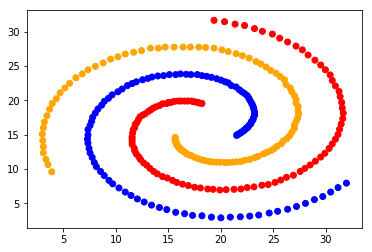

In [9]:
scatter_plot(data_points, data_labels)

In [86]:
x_i = data_points[0]
x_j = data_points[1]
coord = data_points[0].shape[0]
d=[]
for i in range(coord):
    d.append((x_i[i] - x_j[i])**2)

In [93]:
distance_matrix(data_points, eucledian_dist)

array([[ 0.        ,  1.03077641,  1.98494332, ..., 17.47512518,
        17.56680107, 17.60433185],
       [ 1.03077641,  0.        ,  0.95524866, ..., 16.98683314,
        17.09064071, 17.13300908],
       [ 1.98494332,  0.95524866,  0.        , ..., 16.63730747,
        16.75298481, 16.8000744 ],
       ...,
       [17.47512518, 16.98683314, 16.63730747, ...,  0.        ,
         0.25      ,  0.35      ],
       [17.56680107, 17.09064071, 16.75298481, ...,  0.25      ,
         0.        ,  0.1       ],
       [17.60433185, 17.13300908, 16.8000744 , ...,  0.35      ,
         0.1       ,  0.        ]])

In [94]:
distance_matrix(test_matrix,eucledian_dist)

array([[ 0.        , 15.19470696, 19.21924743, 11.68471865, 16.80645508,
         1.75910106],
       [15.19470696,  0.        ,  8.05654889, 18.07427993,  3.15322822,
        15.70518756],
       [19.21924743,  8.05654889,  0.        , 16.74225833,  4.95678038,
        18.99767445],
       [11.68471865, 18.07427993, 16.74225833,  0.        , 17.56851596,
        10.05350743],
       [16.80645508,  3.15322822,  4.95678038, 17.56851596,  0.        ,
        17.01961422],
       [ 1.75910106, 15.70518756, 18.99767445, 10.05350743, 17.01961422,
         0.        ]])

In [41]:
matrix

array([[ 0.        ,  1.03077641,  1.98494332, ..., 17.47512518,
        17.56680107, 17.60433185],
       [ 1.03077641,  0.        ,  0.95524866, ..., 16.98683314,
        17.09064071, 17.13300908],
       [ 1.98494332,  0.95524866,  0.        , ..., 16.63730747,
        16.75298481, 16.8000744 ],
       ...,
       [17.47512518, 16.98683314, 16.63730747, ...,  0.        ,
         0.25      ,  0.35      ],
       [17.56680107, 17.09064071, 16.75298481, ...,  0.25      ,
         0.        ,  0.1       ],
       [17.60433185, 17.13300908, 16.8000744 , ...,  0.35      ,
         0.1       ,  0.        ]])

In [23]:
- distance_matrix(test_matrix, eucledian_dist)**2/0.5

array([[  -0.        , -461.75823909, -738.75894341, -273.06530003,
        -564.91386462,   -6.18887311],
       [-461.75823909,   -0.        , -129.81595997, -653.35919016,
         -19.88569644, -493.30583262],
       [-738.75894341, -129.81595997,   -0.        , -560.60642786,
         -49.13934354, -721.8232687 ],
       [-273.06530003, -653.35919016, -560.60642786,   -0.        ,
        -617.30550593, -202.14602344],
       [-564.91386462,  -19.88569644,  -49.13934354, -617.30550593,
          -0.        , -579.3345365 ],
       [  -6.18887311, -493.30583262, -721.8232687 , -202.14602344,
        -579.3345365 ,   -0.        ]])

array([[1.00000000e+000, 2.89031243e-201, 1.44761234e-321,
        2.56594295e-119, 4.58169153e-246, 2.05213799e-003],
       [2.89031243e-201, 1.00000000e+000, 4.18451302e-057,
        1.77708833e-284, 2.31074364e-009, 5.75438617e-215],
       [1.44761234e-321, 4.18451302e-057, 1.00000000e+000,
        3.40190249e-244, 4.56093894e-022, 3.28199182e-314],
       [2.56594295e-119, 1.77708833e-284, 3.40190249e-244,
        1.00000000e+000, 8.08397810e-269, 1.61844327e-088],
       [4.58169153e-246, 2.31074364e-009, 4.56093894e-022,
        8.08397810e-269, 1.00000000e+000, 2.50154099e-252],
       [2.05213799e-003, 5.75438617e-215, 3.28199182e-314,
        1.61844327e-088, 2.50154099e-252, 1.00000000e+000]])

In [15]:
test_matrix = np.zeros((6,2))
test_matrix[0] = (8.5747873,4.641927)
test_matrix[1] = (2.2325458, -9.165864)
test_matrix[2] = (-5.7608632, -8.159190)
test_matrix[3] = (-2.5327607, 8.268913)
test_matrix[4] = (-0.9201197, -9.225433)
test_matrix[5] = (7.1960156,5.734367)